In [2]:
# Import required libraries
import os
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    UpSampling2D,
    Cropping2D,
    Conv2DTranspose,
    BatchNormalization,
    LeakyReLU,
    concatenate,
    Lambda,
    Activation,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import Metric
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

d:\anaconda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\anaconda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using

In [3]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256
# now im also defininf the paths for each train an val set of images/masks
train_image_dir = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\train_images\train"
train_mask_dir = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\train_masks\train"
val_image_dir = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\val_images\val"
val_mask_dir = r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\val_masks\val"

# Get the list of image and mask file paths
train_image_paths = glob.glob(
    os.path.join(train_image_dir, "*.png")
)  # Adjust if your images are in a different format
train_mask_paths = glob.glob(
    os.path.join(train_mask_dir, "*.tif")
)  # Masks are in .tif format
val_image_paths = glob.glob(
    os.path.join(val_image_dir, "*.png")
)  # Adjust if your images are in a different format
val_mask_paths = glob.glob(
    os.path.join(val_mask_dir, "*.tif")
)  # Masks are in .tif format

In [4]:
# Define F1 score metric
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [5]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    model.summary()
    
    return model

In [6]:
# Build and compile model
IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
# Setup a generator for training
train_image_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_image_generator = train_image_datagen.flow_from_directory(
    r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\train_images",
    target_size=(patch_size, patch_size),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42,
)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\train_masks",
    target_size=(patch_size, patch_size),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42,
)

# Setup a generator for validation
val_image_datagen = ImageDataGenerator(rescale=1.0 / 255)

val_image_generator = val_image_datagen.flow_from_directory(
    r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\val_images",
    target_size=(patch_size, patch_size),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42,
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    r"D:\YearTwoAI\Block B\2024-25b-fai2-adsai-VictoriaVicheva233182\dataset_256_new\val_masks",
    target_size=(patch_size, patch_size),
    batch_size=8,
    class_mode=None,
    color_mode="grayscale",
    seed=42,
)

Found 5428 images belonging to 1 classes.
Found 5428 images belonging to 1 classes.
Found 910 images belonging to 1 classes.
Found 910 images belonging to 1 classes.


In [8]:
def combine_generators(image_generator, mask_generator):
    while True:
        # Get the next batch of images and masks
        images = next(image_generator)
        masks = next(mask_generator)
        yield images, masks



# Combine training generators
train_generator = combine_generators(train_image_generator, train_mask_generator)

# Combine validation generators
val_generator = combine_generators(val_image_generator, val_mask_generator)

In [9]:
# Calculate steps
steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

In [10]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
# Define EarlyStopping callback
cb = EarlyStopping(
    monitor="val_f1",  # Metric to monitor
    patience=20,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True,
    mode='max'  # Restore weights from the epoch with the best value of the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_f1", factor=0.5, patience=8, min_lr=1e-6, mode="max"
)

In [11]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=8,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[cb, reduce_lr],  # Add EarlyStopping here
)

Epoch 1/50
679/679 [==============================] - 177s 225ms/step - loss: 0.0584 - accuracy: 0.9830 - f1: 0.4620 - val_loss: 0.0373 - val_accuracy: 0.9878 - val_f1: 0.7150 - lr: 0.0010
Epoch 2/50
679/679 [==============================] - 73s 107ms/step - loss: 0.0291 - accuracy: 0.9894 - f1: 0.7501 - val_loss: 0.0246 - val_accuracy: 0.9902 - val_f1: 0.7842 - lr: 0.0010
Epoch 3/50
679/679 [==============================] - 72s 107ms/step - loss: 0.0249 - accuracy: 0.9904 - f1: 0.7782 - val_loss: 0.0223 - val_accuracy: 0.9910 - val_f1: 0.8069 - lr: 0.0010
Epoch 4/50
679/679 [==============================] - 72s 106ms/step - loss: 0.0225 - accuracy: 0.9912 - f1: 0.7986 - val_loss: 0.0211 - val_accuracy: 0.9918 - val_f1: 0.8224 - lr: 0.0010
Epoch 5/50
679/679 [==============================] - 73s 107ms/step - loss: 0.0209 - accuracy: 0.9917 - f1: 0.8104 - val_loss: 0.0204 - val_accuracy: 0.9918 - val_f1: 0.8322 - lr: 0.0010
Epoch 6/50
679/679 [==============================] - 73s 1

In [12]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'victoria_233182_unet_model_new_RETAKE_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

victoria_233182_unet_model_new_RETAKE_256px.h5


In [13]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.016548987478017807
Best validation f1: 0.8625555038452148


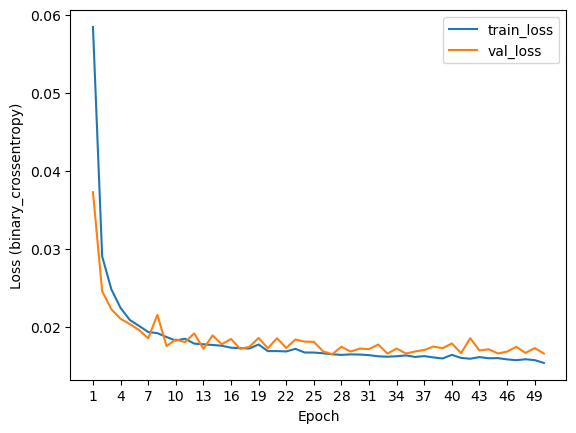

In [14]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

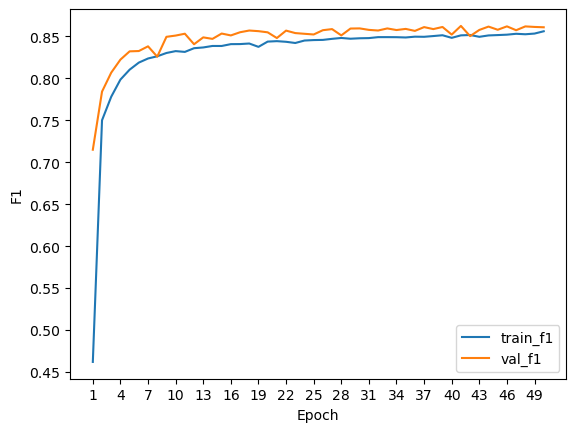

In [15]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))